In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.externals import joblib 
import nltk
import re
import string
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud
from textwrap import wrap
import textblob
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import csv
from sklearn import metrics
from sklearn.metrics import roc_auc_score



In [61]:
Train = pd.read_csv("/content/train_file.csv")
Test = pd.read_csv("/content/test_file.csv")

In [62]:
Train.shape
Test.shape

(37288, 9)

In [63]:
Train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [64]:
Train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


**Duplicates Removal**

In [65]:
duplicateRowsDF = Train[Train.duplicated()]
print(duplicateRowsDF)
Train.drop_duplicates(inplace=True)

Empty DataFrame
Columns: [IDLink, Title, Headline, Source, Topic, PublishDate, Facebook, GooglePlus, LinkedIn, SentimentTitle, SentimentHeadline]
Index: []


**Handling Missing Values**

In [66]:
Train.isnull().sum()


IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [67]:
Test.isnull().sum()


IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [68]:
Train['Source'].value_counts()[:5]


Bloomberg         992
Reuters           763
ABC News          645
New York Times    573
The Guardian      551
Name: Source, dtype: int64

In [69]:
Train['Source'] = Train['Source'].fillna('Bloomberg')
Test['Source'] = Test['Source'].fillna('Bloomberg')

**Data Visualization**

In [70]:
def plot_frequency_charts(df, feature,title):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(8,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} there in news data'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    
    plt.xticks(rotation=90)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


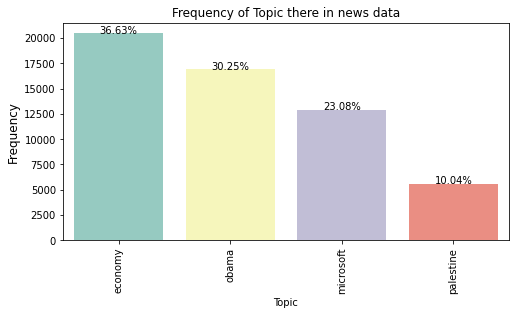

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


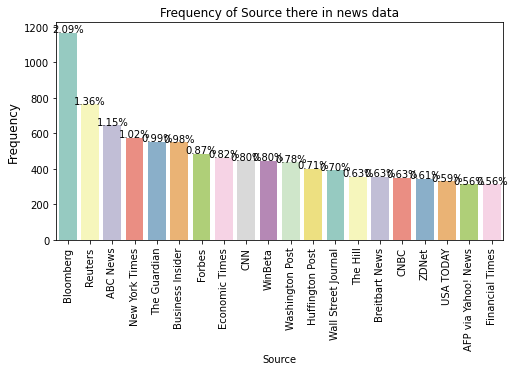

In [71]:

plot_frequency_charts(Train, 'Topic','topic')
plot_frequency_charts(Train, 'Source','source')


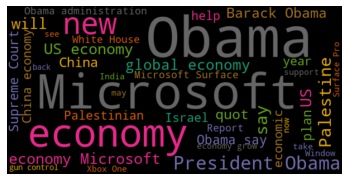

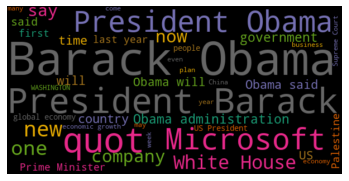

In [72]:
def wordcloud(text):
  wordcloud = WordCloud(colormap="Dark2", width=600, height=300, max_font_size=100, max_words=40).generate(text)
  wordcloud.recolor(random_state=ind*312)
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis("off")
  plt.show()
Title_text = ""
Headline_text = ""
for ind, row in Train.iterrows():
    Title_text += row["Title"] + " "
    Headline_text +=row["Headline"]+" "
Title_text = Title_text.strip()
Headline_text=Headline_text.strip()
wordcloud(Title_text)
wordcloud(Headline_text)
  
      

**Feature Engineering**

In [73]:

Train.PublishDate = pd.to_datetime(Train.PublishDate)
months = Train.PublishDate.dt.month
minutes=Train.PublishDate.dt.minute
years = Train.PublishDate.dt.year
hours=Train.PublishDate.dt.hour
day_name = Train.PublishDate.dt.day_name()
days = pd.get_dummies(day_name)


Test.PublishDate = pd.to_datetime(Test.PublishDate)
months_test= Test.PublishDate.dt.month
minutes_test=Test.PublishDate.dt.minute
years_test = Test.PublishDate.dt.year
hours_test=Test.PublishDate.dt.hour
day_name_test = Test.PublishDate.dt.day_name()
days_test = pd.get_dummies(day_name_test)




In [74]:

Train['year']=years
Train['Month']=months
Train['hour']=hours
Train['minute']=minutes
Train=pd.concat([Train,days],axis=1)
Train.drop('PublishDate',axis=1)
Train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,year,Month,hour,minute,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300,2002,4,0,0,0,0,0,0,0,1,0
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386,2008,9,0,0,0,0,1,0,0,0,0
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754,2012,1,0,0,0,0,1,0,0,0,0
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064,2015,3,0,6,0,0,0,1,0,0,0
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084,2015,3,0,11,0,0,0,1,0,0,0


In [75]:

Test['year']=years
Test['Month']=months
Test['hour']=hours
Test['minute']=minutes
Test=pd.concat([Test,days_test],axis=1)
Test.drop(['PublishDate'],axis=1)
Test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,year,Month,hour,minute,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1,2002,4,0,0,0,0,0,0,0,1,0
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13,2008,9,0,0,0,0,0,0,0,1,0
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0,2012,1,0,0,0,0,0,0,0,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3,2015,3,0,6,0,0,0,0,0,1,0
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0,2015,3,0,11,0,0,0,0,0,1,0


**Text Cleaning**

In [76]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
def stopwords_Removal(text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    output_text = [w for w in word_tokens if not w in stop_words] 
    output = [] 
    for w in word_tokens: 
         if w not in stop_words: 
              output.append(w) 
    return output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:


def clean_text(text):
   text=re.sub('<.*?>', ' ',str(text))
   text = text.translate(str.maketrans(' ',' ',string.punctuation))
   text = re.sub('[^a-zA-Z]',' ',text) 
   text = re.sub("\n"," ",text)
   text = text.lower()
   
   return text

In [78]:
Train["Title"]=Train["Title"].apply(clean_text)
Train["Headline"]=Train["Headline"].apply(clean_text)
Test["Title"]=Test["Title"].apply(clean_text)

Test["Headline"]=Test["Headline"].apply(clean_text)
Train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline,year,Month,hour,minute,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Tr3CMgRv1N,obama lays wreath at arlington national cemetery,obama lays wreath at arlington national cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300,2002,4,0,0,0,0,0,0,0,1,0
1,Wc81vGp8qZ,a look at the health of the chinese economy,tim haywood investment director businessunit h...,Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386,2008,9,0,0,0,0,1,0,0,0,0
2,zNGH03CrZH,nouriel roubini global economy not back to,nouriel roubini nyu professor and chairman at ...,Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754,2012,1,0,0,0,0,1,0,0,0,0
3,3sM1H0W8ts,finland gdp expands in q,finlands economy expanded marginally in the th...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064,2015,3,0,6,0,0,0,1,0,0,0
4,wUbnxgvqaZ,tourism govt spending buoys thai economy in ja...,tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084,2015,3,0,11,0,0,0,1,0,0,0


In [79]:
X_Train_title = Train.drop(['SentimentTitle','SentimentHeadline','IDLink','PublishDate'],axis=1)
y_Train_title = Train['SentimentTitle']

X_Train_headline = Train.drop(['SentimentHeadline','SentimentTitle','IDLink','PublishDate'],axis=1)
y_Train_headline = Train['SentimentHeadline']



In [80]:
Xt_train,Xt_test,yt_train,yt_test = train_test_split(X_Train_title,y_Train_title,test_size = 0.2,random_state = 42)
Xh_train,Xh_test,yh_train,yh_test = train_test_split(X_Train_headline,y_Train_headline,test_size = 0.1,random_state = 42)

In [81]:
Xt_train.head()

,Title,Headline,Source,Topic,Facebook,GooglePlus,LinkedIn,year,Month,hour,minute,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
49320,microsoft is considering compensating xbox liv...,xbox live has been buckling a lot recently dem...,Destructoid,microsoft,46,4,4,2016,3,10,6,1,0,0,0,0,0,0
19939,microsoft launches nokia dual sim priced a...,microsoft launches nokia dual sim priced a...,Times of India,microsoft,15,0,0,2015,12,11,9,0,0,0,0,0,0,1
18804,india may be third largest economy after ...,india could become the worlds third largest ec...,DNA India,economy,2,0,0,2015,12,2,28,0,0,0,1,0,0,0
48701,obama teases trudeau over hockey hints at broa...,us president barack obama and canadian prime m...,CNN,obama,421,0,36,2016,3,9,59,0,0,0,0,1,0,0
35087,obama muslims on tv deserve to be portrayed as...,president barack obama said that muslims in me...,Huffington Post,obama,312,0,0,2016,2,20,45,0,0,0,0,0,0,1


**Text Feature Extraction**

In [82]:
from spacy.lang.en import English
nlp = English()
def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    return mytokens

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
bow_vector = TfidfVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

In [84]:

pipe1= Pipeline([('vectorizer', bow_vector)])
pipe2= Pipeline(
 [('vectorizer', bow_vector)]   
)
Xt_cv = pipe1.fit_transform(list(Xt_train['Title']))
Xt_test_cv = pipe1.transform(list(Xt_test['Title']))


Xh_cv = pipe2.fit_transform(list(Xh_train['Headline']))
Xh_test_cv = pipe2.transform(list(Xh_test['Headline']))


In [85]:
Xt_cv

<44745x100 sparse matrix of type '<class 'numpy.float64'>'
	with 168287 stored elements in Compressed Sparse Row format>

In [86]:
Xh_cv

<50338x100 sparse matrix of type '<class 'numpy.float64'>'
	with 549865 stored elements in Compressed Sparse Row format>

In [87]:
Xt_test_cv

<11187x100 sparse matrix of type '<class 'numpy.float64'>'
	with 41869 stored elements in Compressed Sparse Row format>

In [88]:
Xh_test_cv

<5594x100 sparse matrix of type '<class 'numpy.float64'>'
	with 60674 stored elements in Compressed Sparse Row format>

In [94]:
enc = DictVectorizer()
enc2 = DictVectorizer()
X_train_categ = enc.fit_transform(Xt_train.to_dict('records'))
X_test_categ = enc.transform(Xt_test.to_dict('records'))

X = hstack([Xt_cv,X_train_categ])

X_t = hstack([Xt_test_cv,X_test_categ])

X_h_train_categ = enc2.fit_transform(Xh_train.drop(['Title','Headline'],axis=1).to_dict('records'))
X_h_test_categ = enc2.transform(Xh_test.drop(['Title','Headline'],axis=1).to_dict('records'))

X_h = hstack([Xh_cv,X_h_train_categ])
X_h_t = hstack([Xh_test_cv,X_h_test_categ])


In [95]:
X_h_t
Xh_test_cv
X_h_test_categ

<5594x4554 sparse matrix of type '<class 'numpy.float64'>'
	with 89278 stored elements in Compressed Sparse Row format>

**Linear Regression**

In [96]:

def model_run(classifier,X_train,X_test,y_train,y_test):
  classifier.fit(X_train,y_train)
  print(X_test.shape)
  preds = classifier.predict(X_test)
  return classifier,preds



In [97]:
from sklearn.linear_model import LinearRegression,BayesianRidge
lr = LinearRegression()
lr2 = LinearRegression()
modelt_lr,predst_lr = model_run(lr,X,X_t,yt_train,yt_test)
modelh_lr,predst_lr_h = model_run(lr2,X_h,X_h_t,yh_train,yh_test)

(11187, 85695)
(5594, 4654)


In [98]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,mean_absolute_error,mean_squared_error
print(mean_absolute_error(yt_test,predst_lr),mean_absolute_error(yh_test,predst_lr_h))
score_r = max(0,1-(0.4*(mean_absolute_error(yt_test,predst_lr))+ 0.6*(mean_absolute_error(yh_test,predst_lr_h)))) 
print(score_r)

0.07123471839395236 0.09450142004339576
0.9148052606163816


**Ridge Regression**

In [99]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0, random_state=241)
clf2= Ridge(alpha=1.0, random_state=241)
model,preds = model_run(clf,X,X_t,yt_train,yt_test)
model_h,preds_h = model_run(clf2,X_h,X_h_t,yh_train,yh_test)

(11187, 85695)
(5594, 4654)


In [100]:

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,mean_absolute_error,mean_squared_error
print(mean_absolute_error(yt_test,preds),mean_absolute_error(yh_test,preds_h))
score_r = max(0,1-(0.4*(mean_absolute_error(yt_test,preds))+ 0.6*(mean_absolute_error(yh_test,preds_h)))) 
print(score_r)

0.07377002092863076 0.09331599020629032
0.9145023975047735


**Support vector regression**

In [101]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor_1 = SVR(kernel = 'rbf')
modelt_svm,predst_svr = model_run(regressor,X,X_t,yt_train,yt_test)
modelh_svm,predst_svr_h = model_run(regressor_1,X_h,X_h_t,yh_train,yh_test)

(11187, 85695)
(5594, 4654)


In [102]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,mean_absolute_error,mean_squared_error
print(mean_absolute_error(yt_test,predst_svr),mean_absolute_error(yh_test,predst_svr_h))
score_r = max(0,1-(0.4*(mean_absolute_error(yt_test,predst_svr))+ 0.6*(mean_absolute_error(yh_test,predst_svr_h)))) 
print(score_r)

0.09786632340030224 0.10889931599032236
0.8955138810456857


**Random Forest Regression**

In [103]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 20, random_state = 0)
RF.fit(X,yt_train)
RF_2 = RandomForestRegressor(n_estimators = 20, random_state = 0)
RF_2.fit(X_h,yh_train)
preds_RF = RF.predict(X_t)
preds_RF_h = RF_2.predict(X_h_t)

In [104]:

print(mean_absolute_error(yt_test,preds_RF),mean_absolute_error(yh_test,preds_RF_h))
score = max(0,1-(0.4*mean_absolute_error(yt_test,preds_RF)+ 0.6*mean_absolute_error(yh_test,preds_RF_h))) 
print(score)

0.07395097437775126 0.08693639571045068
0.9182577728226291


**Testing**

In [105]:
X_Test_headline = Test.drop(['IDLink','PublishDate'],axis=1)

In [106]:
X_Test_title = Test.drop(['IDLink','PublishDate'],axis=1)

In [107]:

test_t_cv = pipe1.transform(list(X_Test_title['Title']))
test_h_cv = pipe1.transform(list(X_Test_headline['Headline']))
test_categ_t = enc.transform(X_Test_title.to_dict('records'))
test_categ_h = enc2.transform(X_Test_headline.to_dict('records'))

Xtitle_test = hstack([test_t_cv,test_categ_t])
Xheadline_test=hstack([test_h_cv,test_categ_h])

In [108]:

preds_t_test = model.predict(Xtitle_test)
preds_h_test = model_h.predict(Xheadline_test)

In [109]:

data_ridge= {'IDLink':Test['IDLink'],'SentimentTitle':preds_t_test,'SentimentHeadline':preds_h_test}
final_ridge = pd.DataFrame(data=data_ridge)

In [110]:
final_ridge.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,0.154378,-0.061807
1,DVAaGErjlF,-0.063162,-0.005357
2,OT9UIZm5M2,0.022508,-0.016774
3,lflGp3q2Fj,-0.003237,-0.029752
4,zDYG0SoovZ,0.067796,-0.037737


In [111]:
preds_t_test_lr = modelt_lr.predict(Xtitle_test)
preds_h_test_lr = modelh_lr.predict(Xheadline_test)

In [112]:
linear_reg= {'IDLink':Test['IDLink'],'SentimentTitle':preds_t_test_lr,'SentimentHeadline':preds_h_test_lr}
linear_reg = pd.DataFrame(data=linear_reg)

In [113]:
preds_t_test_svr = modelt_svm.predict(Xtitle_test)
preds_h_test_svr = modelh_svm.predict(Xheadline_test)

In [114]:
svr_reg= {'IDLink':Test['IDLink'],'SentimentTitle':preds_t_test_svr,'SentimentHeadline':preds_h_test_svr}
svr_reg = pd.DataFrame(data=svr_reg)

In [115]:
preds_t_test_rf = RF.predict(Xtitle_test)
preds_h_test_rf = RF_2.predict(Xheadline_test)

In [115]:
rf_reg= {'IDLink':Test['IDLink'],'SentimentTitle':preds_t_test_rf,'SentimentHeadline':preds_h_test_rf}
rf_data = pd.DataFrame(data=rf_reg)

In [115]:
final_ridge.to_csv('/content/zs_submission1.csv',index=False)
linear_reg.to_csv('/content/zs_submission2.csv',index=False)
svr_reg.to_csv('/content/zs_submission3.csv',index=False)
rf_data.to_csv('/content/zs_submission4.csv',index=False)